### Курсовая работа по курсу Python для Data Science

**Задание проекта:**
Используя данные из train.csv,построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Функция для отображения результатов
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

Пути к датасетам

In [4]:
DATASET_PATH = 'train.csv'
DATASET_test = 'test.csv'

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров

* **Price** - цена квартиры


In [5]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [6]:
df_test = pd.read_csv(DATASET_test)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


Работаем с train.csv

### Обзор и приведение типов

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


#### Проводим обзор признаков

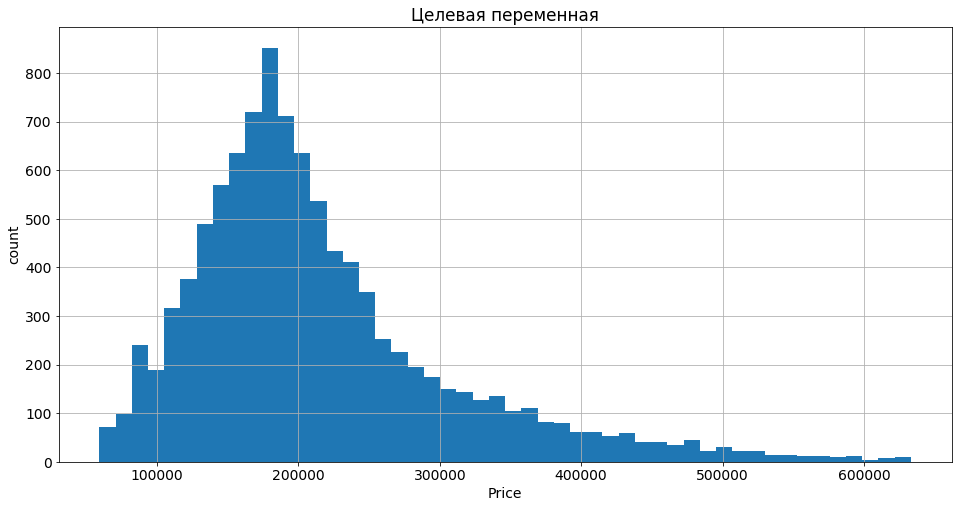

In [8]:
plt.figure(figsize = (16, 8))
df['Price'].hist(bins=50)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Целевая переменная')
plt.show()

#### Проводим обзор признаков

In [9]:
# функция обзора
def show_plt(df):
    plt.hist(df['Square'], bins = 50, alpha = 0.2);
    plt.title('общая площадь')
    plt.show()
    plt.hist(df['LifeSquare'], bins = 50, alpha = 0.2);
    plt.title('жилая площадь')
    plt.show()
    plt.hist(df['KitchenSquare'], bins = 50, alpha = 0.2);
    plt.title('кухня')
    plt.show()

проводим обзор датасета train

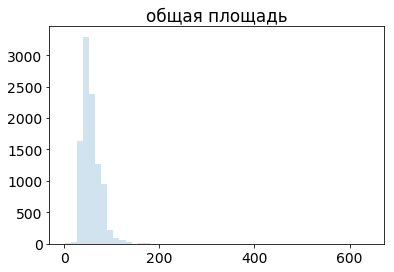

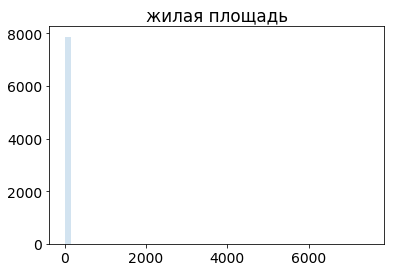

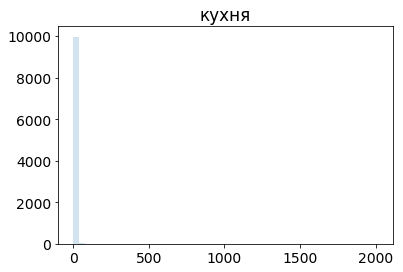

In [10]:
show_plt(df)

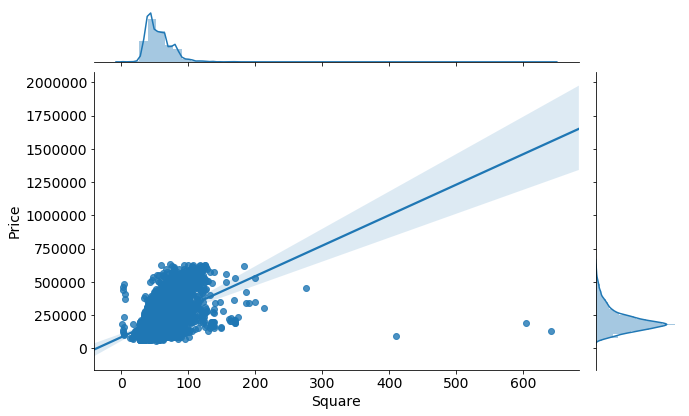

In [11]:
# График распределения цены и общей площади
grid_1 = sns.jointplot(df['Square'],df['Price'], kind = 'reg')
grid_1.fig.set_figwidth(10)
grid_1.fig.set_figheight(6)
plt.show()

In [12]:
df.loc[(df['Square'] > df['LifeSquare'])].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [13]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [14]:
df.loc[df['Floor']>df['HouseFloor']].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,NaN,0,0,B,117000.381287
21,11935,27,2.0,64.711835,NaN,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,127200.026511
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600


In [15]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


проводим обзор датасета test

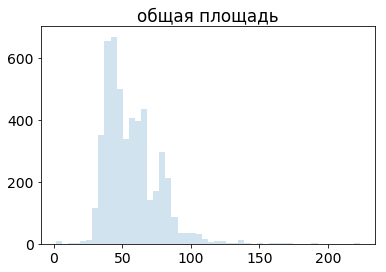

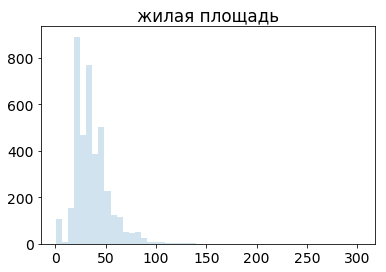

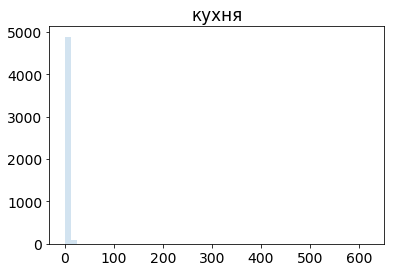

In [16]:
show_plt(df_test)

In [17]:
df_test['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

#### Видим, что имеются выбросы, которые требуют обработки
создадим функцию по предобработке датасета

In [18]:
def prepared (df):
    # обрабатываем ошибочные данные по числу комнат. Заменяем медианой
    df.loc[(df['Rooms']>5) | (df['Rooms']<1),'Rooms']=df['Rooms'].median()
    
    # Обрабатываем выбросы общей площади
    sqr_median = dict(df.groupby('Rooms')['Square'].median())
    pat=((df['Square']>250) | (df['Square']<15))
    df.loc[pat,'Square']=df.loc[pat,'Rooms'].apply(lambda x: sqr_median[x])
    
    # Обрабатываем выбросы жилой площади
    lsqr_median = dict(df.groupby('Rooms')['LifeSquare'].median())
    pat=((df['LifeSquare'].isnull()) | (df['LifeSquare']>150) | (df['LifeSquare']<15))
    df.loc[pat,'LifeSquare']=df.loc[pat,'Rooms'].apply(lambda x: lsqr_median[x])
    df.loc[(df['Square'] > 80) & (df['Rooms'] == 1), 'Rooms'] = df['Rooms'].median()
    
    # Обрабатываем ошибочные данные площади кухни
    df.loc[(df['KitchenSquare']>20) | (df['KitchenSquare']<4),'KitchenSquare'] = df['KitchenSquare'].median()
    
    # обрабатываем общие выбросы по квартире. Считаем, что нежилая площадь в среднем 9 кв.м.
    df.loc[df['Square']<(df['LifeSquare']+df['KitchenSquare']), 'Square'] =\
    df.loc[df['Square']<(df['LifeSquare']+df['KitchenSquare']), 'LifeSquare'] +\
    df.loc[df['Square']<(df['LifeSquare']+df['KitchenSquare']), 'KitchenSquare'] + 9
    
    
    # HouseFloor
    df.loc[df['HouseFloor'] == 0, 'HouseFloor'] = df['HouseFloor'].median()
    floor_idx = df.loc[df['Floor']>df['HouseFloor'],'Floor'].index
    df.loc[floor_idx,'Floor']=df.loc[floor_idx,'HouseFloor'].apply(lambda x: random.randint(1, x))
    
  
    # Заменяем ошибочные данные в HouseYear
    df.loc[df['HouseYear']>2019,'HouseYear']=2019
    
    # Healthcare_1. Заменяем пропуски медианой
    df.loc[df['Healthcare_1'].isnull(),'Healthcare_1']=df['Healthcare_1'].median()
    
    # бинарные признаки
    df['Ecology_2_b']=df['Ecology_2'].replace({'A':0,'B':1})
    df['Ecology_3_b']=df['Ecology_3'].replace({'A':0,'B':1})
    df['Shops_2_b']=df['Shops_2'].replace({'A':0,'B':1})
    
    # Добавляем новые признаки
    df['DistrictId'] = df['DistrictId'].astype(str)
    distr_size = df['DistrictId'].value_counts().reset_index()\
           .rename(columns={'index':'DistrictId', 'DistrictId':'DistrSize'})
    df = df.merge(distr_size, on='DistrictId', how='left')
    df['DistrictLarge'] = (df['DistrSize'] > 100).astype(int) 
    
    return df


Обрабатываем датасет train

In [19]:
df = prepared (df)

Добавляем среднюю цену по району

In [20]:
district_price = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'district_price'})
df = df.merge(district_price, on=['DistrictId', 'Rooms'], how='left')
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_b,Ecology_3_b,Shops_2_b,DistrSize,DistrictLarge,district_price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,22,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,87,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,174,1,263206.223152
3,5809,58,2.0,70.731512,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,179,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,97,0,158539.052715


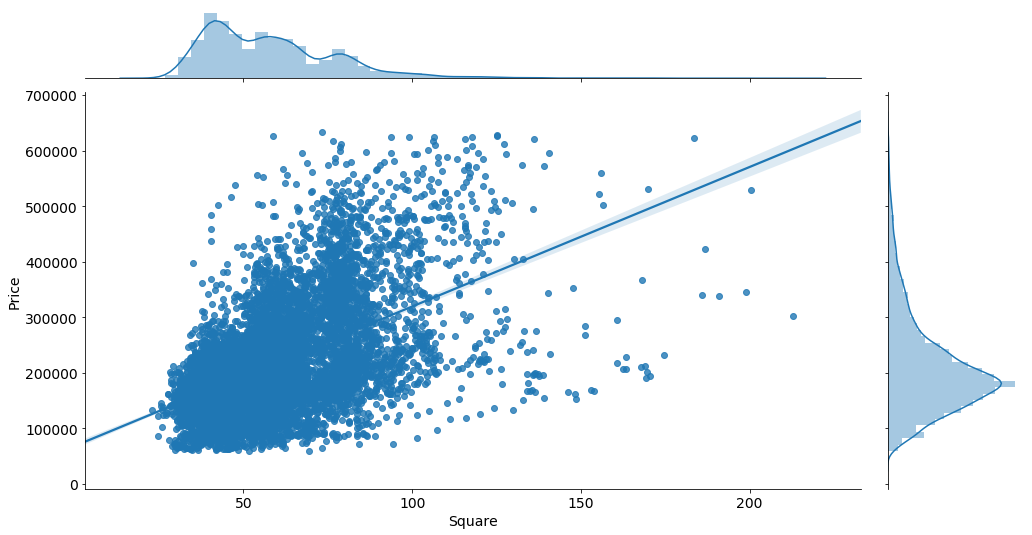

In [21]:
# Проверяем график распределения цены и общей площади
grid_1 = sns.jointplot(df['Square'],df['Price'], kind = 'reg')
grid_1.fig.set_figwidth(16)
grid_1.fig.set_figheight(8)
plt.show()

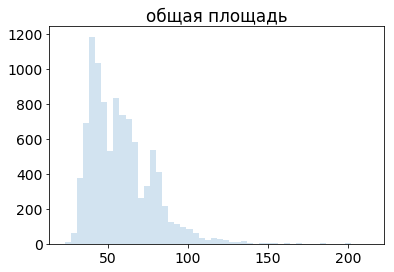

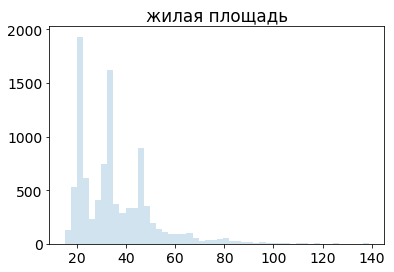

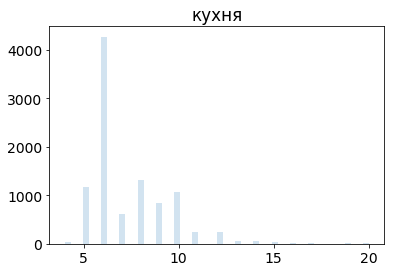

In [22]:
#Проверяем признаки после обработки
show_plt(df)

### Матрица корреляций

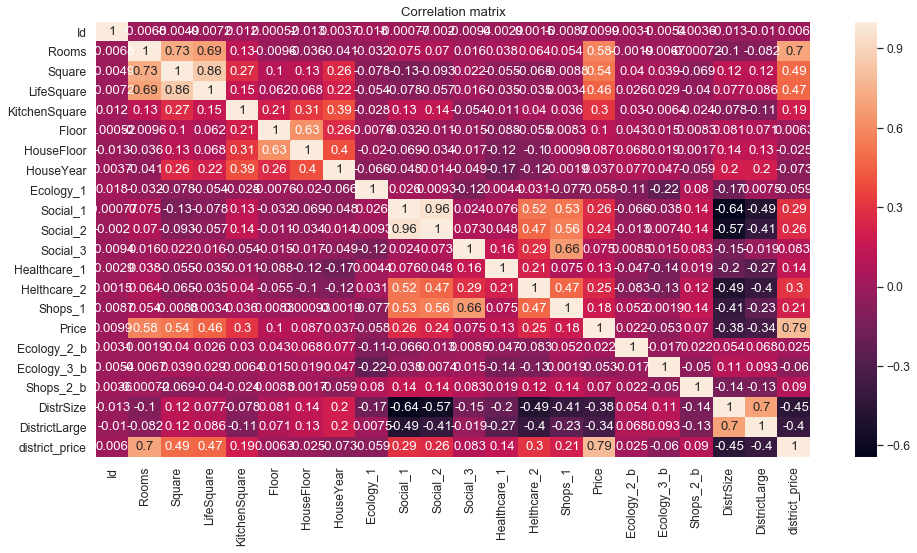

In [23]:
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.1)
sns.heatmap(df.corr(), annot = True)
plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [24]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_b',
 'Ecology_3_b',
 'Shops_2_b',
 'DistrSize',
 'DistrictLarge',
 'district_price']

In [25]:
feature_ = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_b', 'Ecology_3_b', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1','Helthcare_2', 'Shops_1', 'Shops_2_b','DistrSize','DistrictLarge','district_price']

target_ = 'Price'

In [26]:
df=df[feature_+[target_]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_b,Ecology_3_b,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_b,DistrSize,DistrictLarge,district_price,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,...,7976,5,900.0,0,11,1,22,0,207786.135836,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,...,10309,1,240.0,1,16,1,87,0,300009.450063,300009.450063
2,2.0,44.947953,29.197612,6.0,8,12.0,1968,0.049637,1,1,...,7759,0,229.0,1,3,1,174,1,263206.223152,220925.908524
3,2.0,70.731512,52.731512,9.0,8,17.0,1977,0.437885,1,1,...,5735,3,1084.0,0,5,1,179,1,166809.665642,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,...,5776,1,2078.0,2,4,1,97,0,158539.052715,150226.531644


### Стандартизация признаков

In [27]:
feature_stand=[
    'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1',
 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1','district_price','DistrSize'
]

In [28]:
scl = StandardScaler()
scl_f = scl.fit_transform(df[feature_stand])
df[feature_stand]=pd.DataFrame(scl_f,columns=feature_stand)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_b,Ecology_3_b,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_b,DistrSize,DistrictLarge,district_price,Price
0,0.134145,-0.510317,-0.390027,-0.617308,-0.082674,-0.614468,-0.861979,-0.250529,1,1,...,0.654880,-0.127533,-0.169240,-0.883480,1.408356,1,-0.819047,0,-0.050356,184966.930730
1,1.369366,0.383177,0.303538,0.309511,-0.082674,-0.614468,-0.373153,-0.998053,1,1,...,1.237169,-0.295384,-1.053217,-0.213923,2.448700,1,-0.577393,0,1.151364,300009.450063
2,0.134145,-0.663435,-0.406056,-0.617308,0.115728,-0.148856,-0.916293,-0.581588,1,1,...,0.600720,-0.337347,-1.067950,-0.213923,-0.256195,1,-0.253948,1,0.671798,220925.908524
3,0.134145,0.637963,1.132795,0.772921,0.115728,0.627163,-0.427467,2.680470,1,1,...,0.095553,-0.211458,0.077202,-0.883480,0.159943,1,-0.235359,1,-0.584302,175616.227217
4,-1.101076,-0.930885,-0.760557,-0.153898,0.710932,-0.148856,-0.481781,-0.894969,1,1,...,0.105786,-0.295384,1.408526,0.455633,-0.048126,1,-0.540215,0,-0.692072,150226.531644


In [29]:
df[feature_].shape

(10000, 20)

### Разбиение на train и test

In [30]:
X = df[feature_]
y = df[target_]
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, shuffle = True, random_state = 42 )

### Обучение и оценка модели

In [31]:
model_best = GradientBoostingRegressor(n_estimators = 350,max_depth = 5 ,random_state=42, learning_rate=0.05, subsample=0.8)
model_best.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=350, n_iter_no_change=None, presort='auto',
             random_state=42, subsample=0.8, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

R2:	0.908


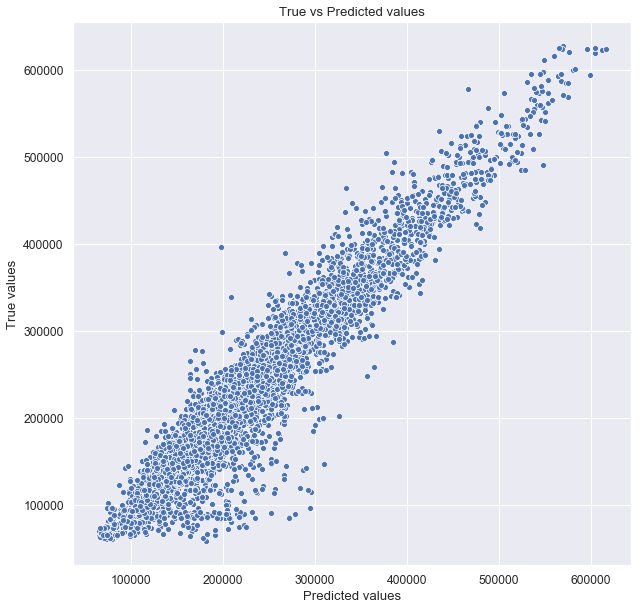

R2:	0.756


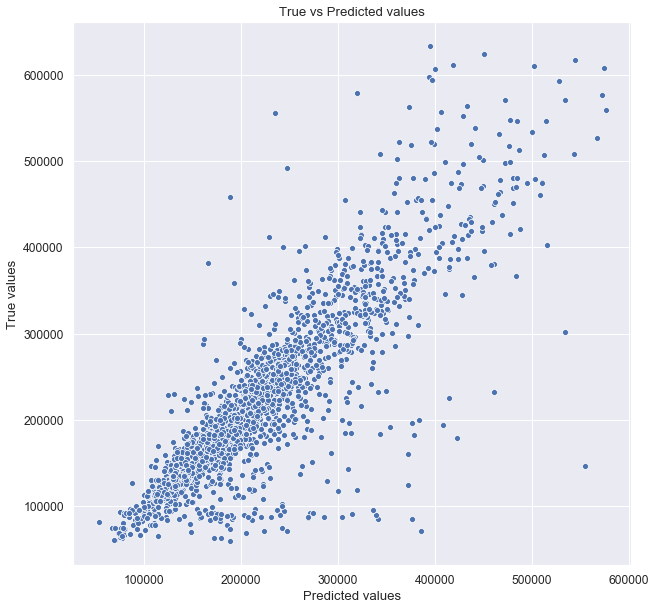

In [32]:
y_pred_=model_best.predict(X_train)
evaluate_preds(y_train, y_pred_)

y_pred_t=model_best.predict(X_test)
evaluate_preds(y_test, y_pred_t)

**Обрабатываем test.csv**

In [33]:
df_test = prepared(df_test)
df_test = df_test.merge(district_price, on=['DistrictId', 'Rooms'], how='left')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
Id                5000 non-null int64
DistrictId        5000 non-null object
Rooms             5000 non-null float64
Square            5000 non-null float64
LifeSquare        5000 non-null float64
KitchenSquare     5000 non-null float64
Floor             5000 non-null int64
HouseFloor        5000 non-null float64
HouseYear         5000 non-null int64
Ecology_1         5000 non-null float64
Ecology_2         5000 non-null object
Ecology_3         5000 non-null object
Social_1          5000 non-null int64
Social_2          5000 non-null int64
Social_3          5000 non-null int64
Healthcare_1      5000 non-null float64
Helthcare_2       5000 non-null int64
Shops_1           5000 non-null int64
Shops_2           5000 non-null object
Ecology_2_b       5000 non-null int64
Ecology_3_b       5000 non-null int64
Shops_2_b         5000 non-null int64
DistrSize         5000 non-null int64
D

In [34]:
df_test.loc[df_test['district_price'].isnull()]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_b,Ecology_3_b,Shops_2_b,DistrSize,DistrictLarge,district_price
2,5480,190,1.0,40.117689,15.948246,12.0,2,5.0,1909,0.000000e+00,...,4702.0,5,5,B,1,1,1,2,0,NaN
51,15748,212,2.0,75.655182,36.877626,15.0,2,7.0,1929,0.000000e+00,...,562.0,1,8,B,1,1,1,1,0,NaN
149,3764,193,4.0,97.931642,72.386905,8.0,5,5.0,1957,3.198094e-01,...,2857.0,5,8,B,1,1,1,1,0,NaN
255,10816,51,3.0,97.889332,58.640564,12.0,4,5.0,1929,1.501689e-02,...,2890.0,0,8,B,1,1,1,8,0,NaN
263,11407,79,4.0,37.920348,21.357487,6.0,6,17.0,2014,3.074667e-01,...,325.0,2,5,B,1,0,1,24,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,2196,52,4.0,104.638510,62.185444,10.0,4,22.0,2005,3.711490e-01,...,750.0,2,5,B,1,1,1,67,0,NaN
4711,429,92,4.0,107.747554,60.377351,13.0,10,17.0,2008,4.605564e-01,...,900.0,1,5,B,1,1,1,7,0,NaN
4719,13426,209,3.0,57.320443,43.187837,6.0,4,5.0,1967,4.024276e-02,...,2729.0,3,1,B,1,1,1,2,0,NaN
4725,15237,115,1.0,31.605210,18.247347,5.0,3,5.0,1962,1.800000e-09,...,1815.0,2,5,B,1,1,1,6,0,NaN


In [35]:
# Заполним пропуски медианой
df_test.loc[df_test['district_price'].isnull(),'district_price']=df_test['district_price'].median()

Стандартизируем признаки

In [36]:
X_scalled = scl.transform(df_test[feature_stand])
df_test[feature_stand]=pd.DataFrame(X_scalled,columns=feature_stand)

Предсказываем цену на недвижимость

In [37]:
y_pred_= model_best.predict(df_test[feature_])
y_pred_

array([157656.37915236, 269917.30164303, 141589.31231589, ...,
       318166.26502297, 189737.13420045, 193739.30941216])

In [38]:
Price_pred = pd.DataFrame({
    'Id': df_test['Id'],
    'Price': y_pred_
})
Price_pred.head()

,Id,Price
0,725,157656.379152
1,15856,269917.301643
2,5480,141589.312316
3,15664,313250.003023
4,14275,125037.489240


Сохраняем предсказание в файл

In [39]:
# Проверяем размерность
Price_pred.shape

(5000, 2)

In [40]:
Price_pred.to_csv('AShabalin_predictions.csv', sep=',', index=False, encoding='utf-8')